## **Histopathologic Cancer Detection using a CNN**
This project aims to create a CNN model to identify metastatic tissue in histopathological scans of lymph node sections.  Histopathology is the branch of pathology that involves the examination of tissues and cells using a microscope to study the changes and abnormalities caused by diseases. In the medical field, histopathology plays a crucial role in the diagnosis, prognosis, and treatment planning of various diseases, including cancers and other pathological conditions.  The application of computer vision techniques in histopathology has revolutionized the field, providing faster and more accurate diagnoses, improved research capabilities, and better patient outcomes.

In [1]:
#Load the libraries
import numpy as np
import pandas as pd
import os
import gc
from glob import glob
from skimage.io import imread
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.python.ops.gen_linalg_ops import batch_cholesky
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

The dataset used for this project came from the  Histopathologic Cancer Detection kaggle competition.[https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview/description](http://)
The data is a slightly modified version of the PatchCamelyon (PCAM) benchmark dataset.  This dataset contains a large number of small pathology images to classify.  A train_labels.csv files provides the ground truth for the images in the train folder.  The model will predict the labels for the images in the test folder.  A postive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue.  The train data we have here contains 220,025 images and the test set contains 57,458 images.


In [2]:
from google.colab import files
uploaded = files.upload() # Please upload your kaggle.json file

Saving kaggle.json to kaggle.json


In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
"chmod 600 /content/kaggle.json"

'chmod 600 /content/kaggle.json'

In [4]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.31G/6.31G [05:40<00:00, 23.5MB/s]
100% 6.31G/6.31G [05:40<00:00, 19.9MB/s]


In [5]:
%%capture
!unzip "./histopathologic-cancer-detection.zip"

In [6]:
os.listdir("./")

['.config',
 'histopathologic-cancer-detection.zip',
 'train',
 'sample_submission.csv',
 'test',
 'kaggle.json',
 'train_labels.csv',
 'sample_data']

## EDA

First we will take a look at the data to get a better understanding of what we are working with.

In [7]:
# Add a .tif extension to a new coloumn "file_id"
train_labels = pd.read_csv("./train_labels.csv")
train_labels["file_id"] = train_labels["id"] + ".tif"

In [8]:
train_labels

,id,label,file_id
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif
...,...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6.tif
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1,d4b854fe38b07fe2831ad73892b3cec877689576.tif
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75.tif
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0,f129691c13433f66e1e0671ff1fe80944816f5a2.tif


In [9]:
print("Train Size: {}".format(len(os.listdir("./train/"))))
print("Test Size: {}".format(len(os.listdir("./test/"))))

Train Size: 220025
Test Size: 57458


(-1.1308643348043863,
 1.1014690432011327,
 -1.104777648173446,
 1.2003527442703625)

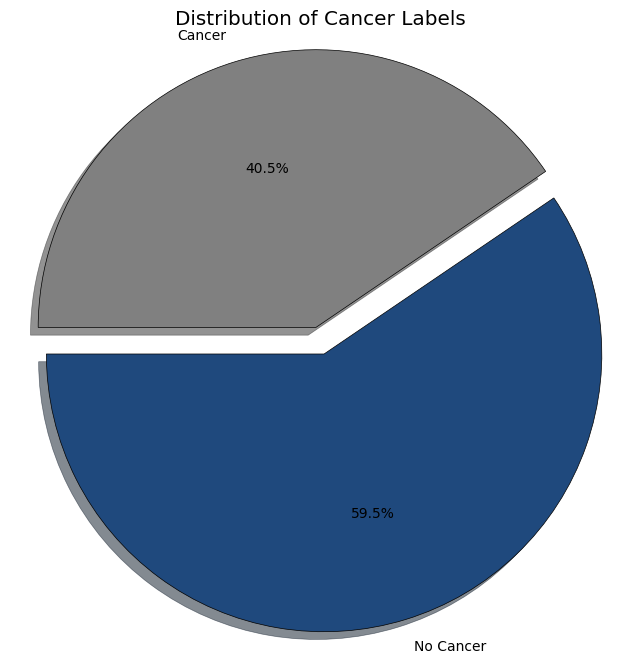

In [10]:
labels_count = train_labels.label.value_counts()

labels = ['No Cancer', 'Cancer']
colors = ['#1f497d', '#808080']

explode = (0, 0.1)

plt.figure(figsize=(8, 8))

plt.pie(labels_count, labels=labels, colors=colors, explode=explode,
        startangle=180, autopct='%1.1f%%', shadow=True, wedgeprops={'edgecolor': 'black'})
plt.title('Distribution of Cancer Labels')
plt.axis('equal')

So we have slight imbalnced data of ~60% no cancer labels and ~40% cancer labels.

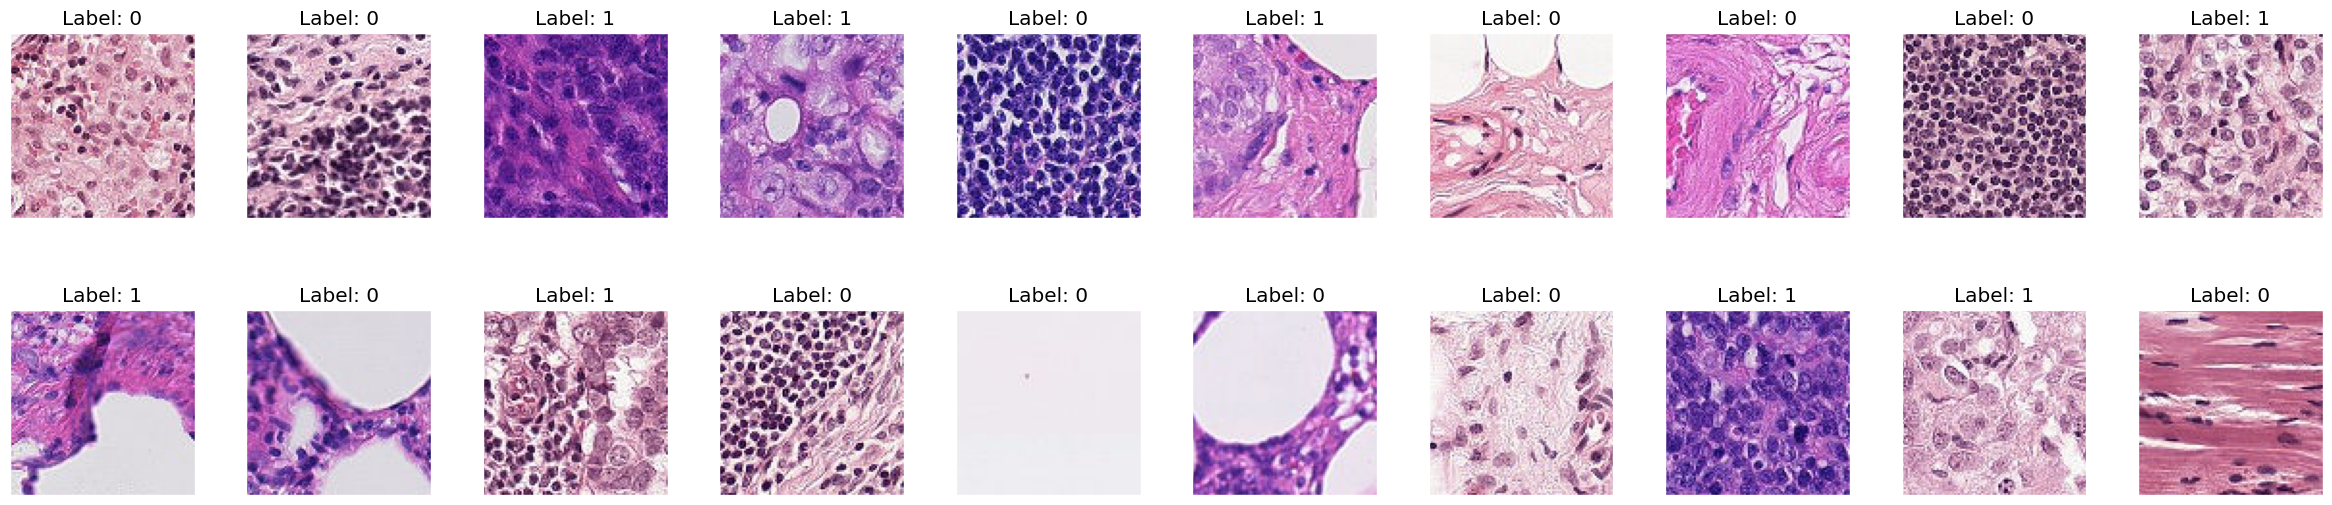

In [11]:
train_imgs = os.listdir("./train/")
num_images_to_display = 20

# Create the figure and set its size in the same function call
fig, axes = plt.subplots(2, num_images_to_display // 2, figsize=(30, 6))
fig.subplots_adjust(hspace=0.5)  # Adjust vertical space between subplots

# Randomly select images to display
selected_images = np.random.choice(train_imgs, num_images_to_display, replace=False)

for idx, img in enumerate(selected_images):
    ax = axes[idx // (num_images_to_display // 2), idx % (num_images_to_display // 2)]
    ax.set_xticks([])
    ax.set_yticks([])
    im = Image.open("./train/" + img)
    ax.imshow(im)
    lab = train_labels.loc[train_labels['id'] == img.split('.')[0], 'label'].values[0]
    #lab = train_labels.loc[train_labels['id'] == 'label'].values[0]
    ax.set_title('Label: %s' % lab)

Taking a look at a few images to get an idea of what they are.  I don't know much about cellular biology but they are interesting to look at.

In [12]:
sample_fraction = 0.7  # Fraction of positive and negative samples to keep
train_labels_pos = train_labels.loc[train_labels["label"] == 1].sample(frac=sample_fraction, random_state=42)
train_labels_neg = train_labels.loc[train_labels["label"] == 0].sample(frac=sample_fraction, random_state=42)
train_labels = pd.concat([train_labels_pos, train_labels_neg], ignore_index=True)

We will create a balanced dataset of positive and negative samples.

In [13]:
#Shape after creating balanced dataset.
train_labels.shape

(154018, 3)

In [14]:
train_labels['label'] = train_labels['label'].astype(str)

# Perform a train-test split with stratification based on the 'label' column
train_data, val_data = train_test_split(train_labels, test_size=0.1, stratify=train_labels["label"])

# Reset the indices of the newly split DataFrames for consistency
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

# Get the size of the training and validation datasets
len_train = train_data.shape[0]
len_val = val_data.shape[0]

# Print the sizes of the training and validation datasets
print("Training data size: {}.".format(len_train))
print("Validation data size: {}.".format(len_val))

# Free up memory by deleting the original DataFrame
del train_labels
gc.collect()

Training data size: 138616.
Validation data size: 15402.


2541

Next we prepare the data for training by performing a train-test split.

In [15]:
img_gen_params = {
    "rescale": 1.0 / 255,
    "samplewise_center": True,
    "samplewise_std_normalization": True,
    "horizontal_flip": True,
    "vertical_flip": True,
    "rotation_range": 20,
    "zoom_range": 0.2,
    "width_shift_range": 0.1,
    "height_shift_range": 0.1,
    "brightness_range": [0.8, 1.2]
}
img_gen = ImageDataGenerator(**img_gen_params)

In [16]:
IMAGE_SHAPE = (96, 96, 3)
path_train = "./train/"
batch_size = 32

In [17]:
img_flow_params_train = {
    "dataframe": train_data,
    "directory": path_train,
    "x_col": "file_id",
    "y_col": "label",
    "has_ext": True,
    "target_size": IMAGE_SHAPE[:2],
    "class_mode": "binary",
    "batch_size": batch_size
}
img_flow_train = img_gen.flow_from_dataframe(**img_flow_params_train)

Found 138616 validated image filenames belonging to 2 classes.


In [18]:
img_flow_params_val = {
    "dataframe": val_data,
    "directory": path_train,
    "x_col": "file_id",
    "y_col": "label",
    "has_ext": True,
    "target_size": IMAGE_SHAPE[:2],
    "class_mode": "binary",
    "batch_size": 1,
    "shuffle": False
}
img_flow_val = img_gen.flow_from_dataframe(**img_flow_params_val)

Found 15402 validated image filenames belonging to 2 classes.


We augment the data to increase the size of the dataset by applying random transformaitons to the images, such as rotation, zooming, shifting, flipping, and adjusting brightness.  The augmented versions of the images lead to a more diverse and robust dataset for training the CNN.

## **Modeling**

In [19]:

# Build the model using the functional API
i = Input(shape=IMAGE_SHAPE)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(2, activation='softmax')(x)

model = Model(i, x)

First we will try a typical CNN architecture used for image classification tasks. It consists of convolutional layers to extract meaningful features, followed by fully connected layers for classification. The use of batch normalization and dropout layers helps improve the model's performance and generalization capabilities. The final output layer uses the softmax activation function to produce class probabilities for binary classification (2 classes).

In [20]:
# Compile and fit
batch_size = 32
steps_per_epoch = train_data.shape[0] // batch_size
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
r = model.fit_generator(img_flow_train, validation_data=img_flow_val, steps_per_epoch=steps_per_epoch, epochs=25)

Epoch 1/25
4331/4331 [==============================] - 545s 122ms/step - loss: 0.4639 - accuracy: 0.8152 - val_loss: 0.3515 - val_accuracy: 0.8514
Epoch 2/25
4331/4331 [==============================] - 535s 124ms/step - loss: 0.3590 - accuracy: 0.8497 - val_loss: 0.3199 - val_accuracy: 0.8691
Epoch 3/25
4331/4331 [==============================] - 536s 124ms/step - loss: 0.3085 - accuracy: 0.8750 - val_loss: 0.2870 - val_accuracy: 0.8777
Epoch 4/25
4331/4331 [==============================] - 535s 123ms/step - loss: 0.2666 - accuracy: 0.8965 - val_loss: 0.2612 - val_accuracy: 0.9018
Epoch 5/25
4331/4331 [==============================] - 536s 124ms/step - loss: 0.2453 - accuracy: 0.9058 - val_loss: 0.2287 - val_accuracy: 0.9092
Epoch 6/25
4331/4331 [==============================] - 534s 123ms/step - loss: 0.2264 - accuracy: 0.9147 - val_loss: 0.3059 - val_accuracy: 0.8850
Epoch 7/25
4331/4331 [==============================] - 534s 123ms/step - loss: 0.2157 - accuracy: 0.9190 - val_

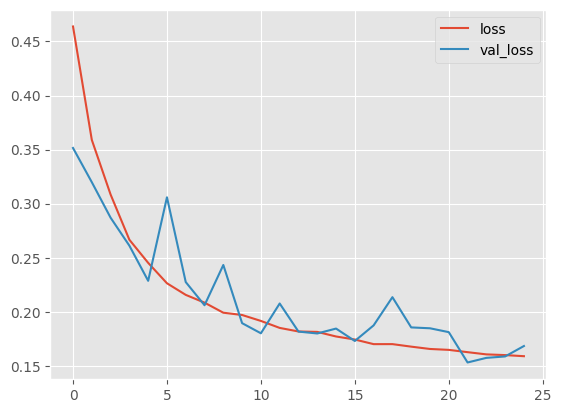

In [21]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

So the model looks to have converged nicely.

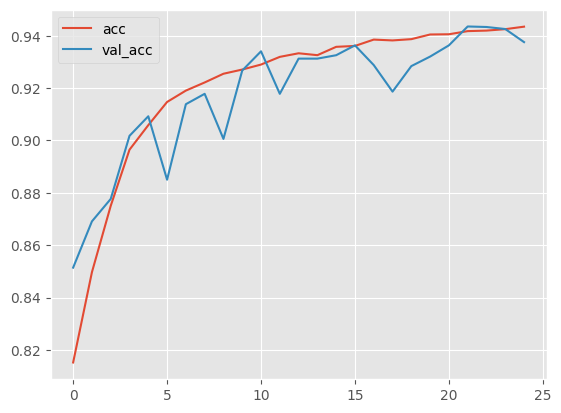

In [22]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label = 'val_acc')
plt.legend()

The model had ~94% validation accuracy which is pretty good.

In [23]:
y_val_pred = model.predict_generator(img_flow_val, steps=len_val)[:, 1]
y_val_true = img_flow_val.classes
acc_val = np.equal((y_val_pred > 0.5).astype("int"), y_val_true).sum() / y_val_pred.shape[0]
print("Validation accuracy: {:.3f}.".format(acc_val))

Validation accuracy: 0.938.


The validation area under the curve is 0.985.

In [24]:
fpr, tpr, thresholds = roc_curve(y_val_true, y_val_pred)
auc_val = auc(fpr, tpr)
print("Validation AUC: {:.3f}.".format(auc_val))

Validation AUC: 0.985.


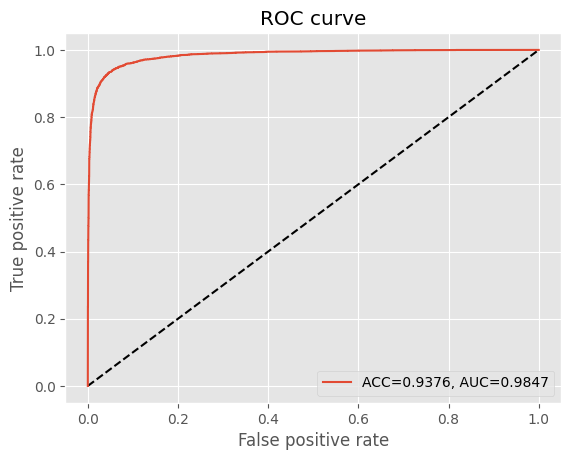

In [25]:
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="ACC={:.4F}, AUC={:.4f}".format(acc_val, auc_val))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.legend(loc="best")

Next we try a larger convolutional filter size and adding an extra max pooling layer.

In [26]:
# Build the model using the functional API
i2 = Input(shape=IMAGE_SHAPE)
x2 = Conv2D(32, (5, 5), activation='relu', padding='same')(i2)
x2 = BatchNormalization()(x2)
x2 = Conv2D(32, (5, 5), activation='relu', padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D((2, 2))(x2)
x2 = Conv2D(64, (5, 5), activation='relu', padding = 'same')(x2)
x2 = BatchNormalization()(x2)
x2 = Conv2D(64, (5, 5), activation='relu', padding = 'same')(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D((2, 2))(x2)
x2 = Conv2D(128, (5, 5), activation='relu', padding = 'same')(x2)
x2 = BatchNormalization()(x2)
x2 = Conv2D(128, (5, 5), activation='relu', padding = 'same')(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D((2, 2))(x2)
x2 = Conv2D(128, (5, 5), activation='relu', padding = 'same')(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D((2, 2))(x2)

x2 = Flatten()(x2)
x2 = Dropout(0.2)(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.2)(x2)
x2 = Dense(2, activation='softmax')(x2)

model2 = Model(i2, x2)

In [27]:
# Compile and fit
batch_size = 32
steps_per_epoch = train_data.shape[0] // batch_size
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
r2 = model2.fit_generator(img_flow_train, validation_data=img_flow_val, steps_per_epoch=steps_per_epoch, epochs=25)

Epoch 1/25
4331/4331 [==============================] - 539s 123ms/step - loss: 0.4568 - accuracy: 0.8106 - val_loss: 0.3729 - val_accuracy: 0.8433
Epoch 2/25
4331/4331 [==============================] - 533s 123ms/step - loss: 0.3460 - accuracy: 0.8553 - val_loss: 0.3005 - val_accuracy: 0.8737
Epoch 3/25
4331/4331 [==============================] - 531s 123ms/step - loss: 0.2956 - accuracy: 0.8810 - val_loss: 0.3755 - val_accuracy: 0.8340
Epoch 4/25
4331/4331 [==============================] - 530s 122ms/step - loss: 0.2592 - accuracy: 0.8979 - val_loss: 0.2203 - val_accuracy: 0.9133
Epoch 5/25
4331/4331 [==============================] - 530s 122ms/step - loss: 0.2334 - accuracy: 0.9097 - val_loss: 0.2786 - val_accuracy: 0.8961
Epoch 6/25
4331/4331 [==============================] - 532s 123ms/step - loss: 0.2191 - accuracy: 0.9165 - val_loss: 0.2249 - val_accuracy: 0.9132
Epoch 7/25
4331/4331 [==============================] - 531s 123ms/step - loss: 0.2069 - accuracy: 0.9218 - val_

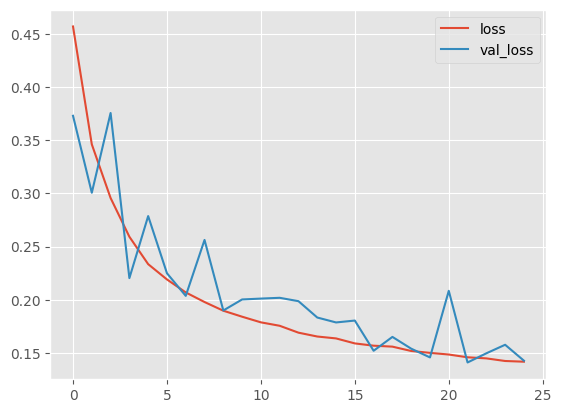

In [28]:
# Plot loss per iteration
plt.plot(r2.history['loss'], label='loss')
plt.plot(r2.history['val_loss'], label='val_loss')
plt.legend()

Again the model converges nicely.  Accuray doesn't approve more than ~94% so the simpler model is preferable.

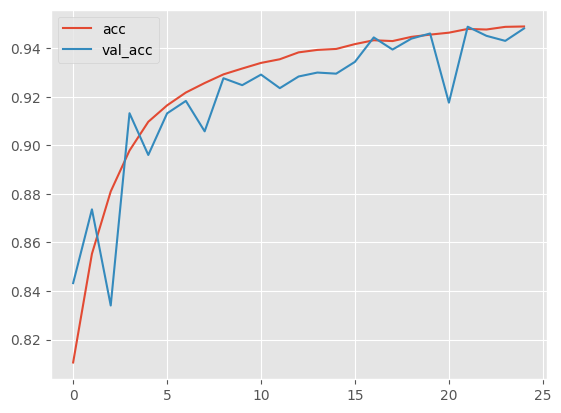

In [29]:
# Plot accuracy per iteration
plt.plot(r2.history['accuracy'], label='acc')
plt.plot(r2.history['val_accuracy'], label = 'val_acc')
plt.legend()

## **Tune Hyperparameters**

Next we will do a gridsearch to tune the hyperparameters.

*Please note that I ended up not running this cell due to limited GPU time.  To run this notebook with the full gridsearch would have taken longer than the 30 hour limit on kaggle.  I tried running a few time on Colab pro but after a few disconnects before finishing I got tired of throwing money away.  I manually changed many of the hyperparameters while creating the models and always seemed to get ~94% accuracy so I don't think gridsearch would have helped much anyway.

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

def create_model():
    i = Input(shape=IMAGE_SHAPE)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(2, activation='softmax')(x)

    model = Model(i, x)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

keras_model = KerasClassifier(build_fn=create_model)

# Define hyperparameter grid for grid search
param_grid = {
    'learning_rate': [0.001, 0.01],
    'dropout_rate': [0.2, 0.3, 0.4],
}

# Perform grid search
grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_result = grid.fit(img_flow_train, img_flow_val)

# Print the best hyperparameters and corresponding accuracy
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

### Conclusion

The first model trained achieved the highest auc in kaggle submission. It consists of 6 layers of Conv-Batch Normalization units with a Pooling unit added every 2 layers. Followed by  2 layers of 20% dropout-dense units.

Convolution layers help to mitigate overfitting.  The more convolution layers added the higher the validation accuracy and the training data overfit less. This was observed only up to a point where validation accuracy seemed to plateau.

Dropout layers improved validation accuracy.  20% seemed to produce the highest validation accuracy.  10% and 30% produced similar accuracies but going higher then 30% started showing a decrease in validation accuracy.

Augmenting the images was effective in producing a higher accuracy.  



### Submission

In [1]:
test_df = pd.read_csv('../input/sample_submission.csv')

from matplotlib.pyplot import imread
# Kaggle testing
TESTING_BATCH_SIZE = 64
testing_files = glob(os.path.join('../input/test/','*.tif'))
submission = pd.DataFrame()
print(len(testing_files))
for index in range(0, len(testing_files), TESTING_BATCH_SIZE):
    data_frame = pd.DataFrame({'path': testing_files[index:index+TESTING_BATCH_SIZE]})
    data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[3].split(".")[0])
    data_frame['image'] = data_frame['path'].map(imread)
    images = np.stack(data_frame.image, axis=0)
    predicted_labels = [model.predict(np.expand_dims(image/255.0, axis=0))[0][0] for image in images]
    predictions = np.array(predicted_labels)
    data_frame['label'] = predictions
    submission = pd.concat([submission, data_frame[["id", "label"]]])
    if index % 1000 == 0 :
        print(index/len(testing_files) * 100)
submission.to_csv('submission_new_model.csv', index=False, header=True)
print(submission.head())

### References

Kuang, Kaiming. (2018). Tumor Detection with Keras CNN. https://www.kaggle.com/code/kaimingk/tumor-detection-with-keras-cnn
Leekang. (2019). CNN_Conv2D+SeparableConv2D_keras_new_model_1. https://www.kaggle.com/code/leeking/cnn-conv2d-separableconv2d-keras-new-model-1

Lazy Programmer.  

https://www.deeplearningbook.org/contents/convnets.html